# Parse Music XML files instead
Sine Sat. Nov. 13th, 2021



`From Merry Go Round of Life` MIDI file is a challenging one if just to process the raw MIDI file,
due to quality of transcription, where there's slight times where time signature changes, and that comes with many tempos

Hopefully there's some way to process the symbolic representation in Music XML format,
as we need to get the bar separations,
i.e. each bar contains the corresponding notes


## Setup



In [1]:
import os

import pandas as pd
import music21
from icecream import ic

from util import *



## music21

`From Merry Go Round of Life` MIDI file, exported using `MuseScore`



In [2]:
dset = 'MIDI_EG'
dir_nm = config(f'{DIR_DSET}.{dset}.dir_nm')
fnm = os.path.join(
    PATH_BASE,
    DIR_DSET,
    dir_nm,
    'Joe Hisaishi - Merry Go Round of Life (bitmidi).mxl'
)
ic(fnm)


def get_notes(fl):
    # Modified from https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S2_MusicXML.html
    """
    Convert a music xml file to a list of note events

    :param fl: MusicXML file path or `music21.stream.Score`
    :returns: score: List of `[start, duration, pitch, velocity, instrument]`
    """
    if isinstance(fl, str):
        fl = music21.converter.parse(fl)

    def _get_part(p_):
        instr = p_.getInstrument().instrumentName

        def _get(note_):
            strt = note_.offset
            dur_ = note_.quarterLength
            vol = note_.volume.realized
            def _one(pitch):
                return strt, dur_, pitch, vol, instr

            return [_one(p__.ps) for p__ in note_.pitches] if note_.isChord else [_one(note_.pitch.ps)]
        return flatten([_get(n_) for n_ in p_.flat.notes])
    notes = flatten([_get_part(p_) for p_ in fl.parts])
    return sorted(notes, key=lambda x: (x[0], x[2]))


lst_notes = get_notes(fnm)
df = pd.DataFrame(lst_notes, columns=['start', 'duration', 'pitch', 'velocity', 'instrument'])
ic(df.head(6))



ic| fnm: ('/Users/stefanh/Documents/UMich/Research/Music with NLP/datasets/MIDI-eg/Joe '
          'Hisaishi - Merry Go Round of Life (bitmidi).mxl')
ic| df.head(6):   start duration  pitch  velocity instrument
                0   6.0      0.5   70.0       1.0      Piano
                1   6.0      0.5   74.0       1.0      Piano
                2   6.5      0.5   72.0       1.0      Piano
                3   6.5      0.5   75.0       1.0      Piano
                4   7.0      0.5   70.0       1.0      Piano
                5   7.0      0.5   74.0       1.0      Piano


,start,duration,pitch,velocity,instrument
0,6.0,0.5,70.0,1.0,Piano
1,6.0,0.5,74.0,1.0,Piano
2,6.5,0.5,72.0,1.0,Piano
3,6.5,0.5,75.0,1.0,Piano
4,7.0,0.5,70.0,1.0,Piano
5,7.0,0.5,74.0,1.0,Piano


### Parse an MXL
Following [User’s Guide, Chapter 6: Streams (II): Hierarchies, Recursion, and Flattening]
(https://web.mit.edu/music21/doc/usersGuide/usersGuide_06_stream2.html#accessing-scores-parts-measures-and-notes)



In [12]:
s = music21.converter.parse(fnm)
ic(s, type(s), len(s))
# ic(vars(s))

for idx, e in enumerate(s):
    ic(idx, e)
ic('\n')

for p in s.parts:
    ic(p)
ic('\n')

for e in list(s.recurse())[:30]:
    ic(e)



ic| s: <music21.stream.Score 0x16bab9730>
    type(s): <class 'music21.stream.base.Score'>
    len(s): 6
ic| idx: 0, e: <music21.metadata.Metadata object at 0x16bfeee80>
ic| idx: 1, e: <music21.stream.Part Violin, CH #1>
ic| idx: 2, e: <music21.stream.Part Piano, CH #2>
ic| idx: 3, e: <music21.stream.Part Piano, CH #3>
ic| idx: 4, e: <music21.stream.Part Piano, CH #4>
ic| idx: 5, e: <music21.layout.ScoreLayout>
ic| '\n': '
           '
ic| p: <music21.stream.Part Violin, CH #1>
ic| p: <music21.stream.Part Piano, CH #2>
ic| p: <music21.stream.Part Piano, CH #3>
ic| p: <music21.stream.Part Piano, CH #4>
ic| '\n': '
           '
ic| e: <music21.metadata.Metadata object at 0x16bfeee80>
ic| e: <music21.stream.Part Violin, CH #1>
ic| e: <music21.instrument.Violin 'P1: Violin, CH #1: Violin'>
ic| e: <music21.stream.Measure 0 offset=0.0>
ic| e: <music21.layout.SystemLayout>
ic| e: <music21.clef.TrebleClef>
ic| e: <music21.tempo.MetronomeMark Quarter=240.0>
ic| e: <music21.key.KeySignature of 1

### How do I get the bars?
The **Accessing Scores, Parts, Measures, and Notes** section



ic| part_ch2: <music21.stream.Part Piano, CH #2>
ic| part_ch2.measure(1): <music21.stream.Measure 1 offset=3.0>
ic| m: <music21.instrument.Piano 'P2: Piano, CH #2: Piano'>
    type(m): <class 'music21.instrument.Piano'>
ic| m: <music21.stream.Measure 0 offset=0.0>
    type(m): <class 'music21.stream.base.Measure'>
ic| m: <music21.stream.Measure 1 offset=3.0>
    type(m): <class 'music21.stream.base.Measure'>
ic| m: <music21.stream.Measure 2 offset=6.0>
    type(m): <class 'music21.stream.base.Measure'>
ic| m: <music21.stream.Measure 3 offset=9.0>
    type(m): <class 'music21.stream.base.Measure'>
ic| len(measures): 167
    type(measures): <class 'music21.stream.base.Part'>
    type(measures[0]): <class 'music21.instrument.Piano'>
    type(part_ch2.measure(0)): <class 'music21.stream.base.Measure'>


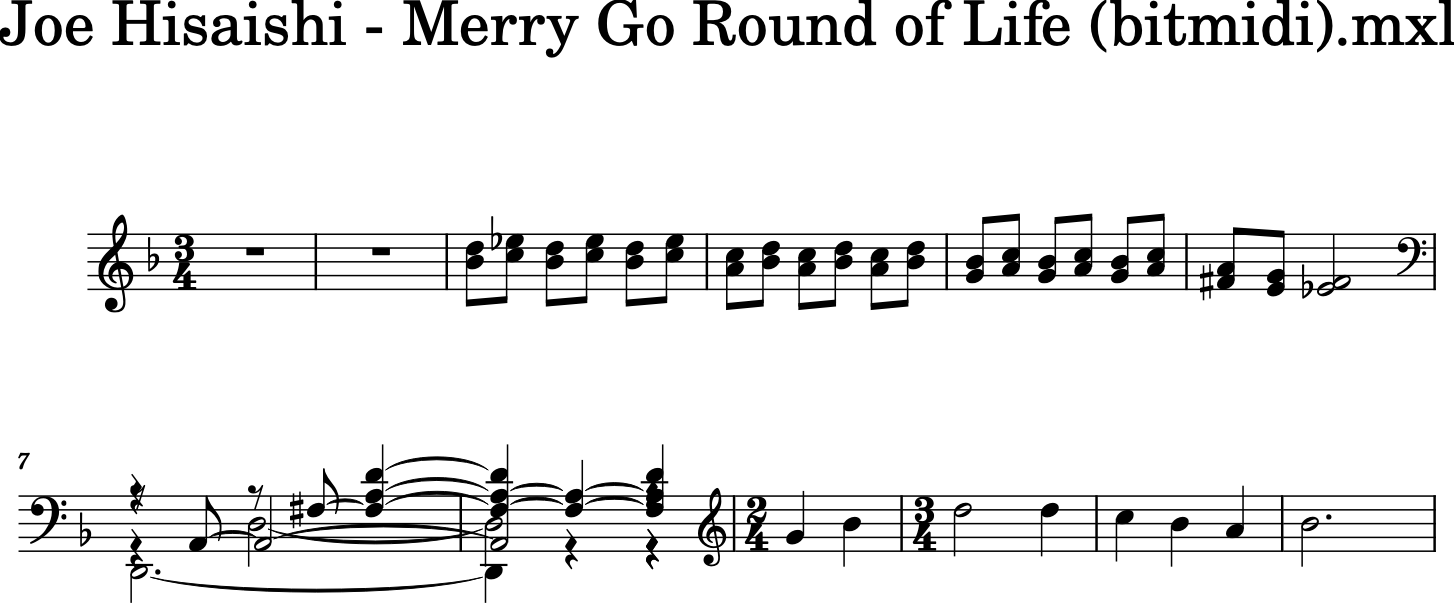

ic| measures.show(): None


In [4]:
part_ch2: music21.stream.Part = s[2]
ic(part_ch2)
ic(part_ch2.measure(1))
measures = part_ch2.measures(numberStart=0, numberEnd=None)  # Get all measures
for m in list(measures)[:5]:
    ic(m, type(m))

ic(len(measures), type(measures), type(measures[0]), type(part_ch2.measure(0)))
ic(measures.show())



# Does all channels have the same number of measures?
Looks like the first/0-th measure of any part is always a special instrument measure



In [5]:
for p in s.parts:
    ic(len(p.measures(numberStart=0, numberEnd=None)))


part_ch1 = s.parts[0]
for m in part_ch1.measures(numberStart=0, numberEnd=10):
    ic(m)



ic| len(p.measures(numberStart=0, numberEnd=None)): 167
ic| len(p.measures(numberStart=0, numberEnd=None)): 167
ic| len(p.measures(numberStart=0, numberEnd=None)): 167
ic| len(p.measures(numberStart=0, numberEnd=None)): 167
ic| m: <music21.instrument.Violin 'P1: Violin, CH #1: Violin'>
ic| m: <music21.stream.Measure 0 offset=0.0>
ic| m: <music21.stream.Measure 1 offset=3.0>
ic| m: <music21.stream.Measure 2 offset=6.0>
ic| m: <music21.stream.Measure 3 offset=9.0>
ic| m: <music21.stream.Measure 4 offset=12.0>
ic| m: <music21.stream.Measure 5 offset=15.0>
ic| m: <music21.stream.Measure 6 offset=18.0>
ic| m: <music21.stream.Measure 7 offset=21.0>
ic| m: <music21.stream.Measure 8 offset=24.0>
ic| m: <music21.stream.Measure 9 offset=26.0>
ic| m: <music21.stream.Measure 10 offset=29.0>


### Get the notes in a measure
#### A chord
We have the duration of each notes



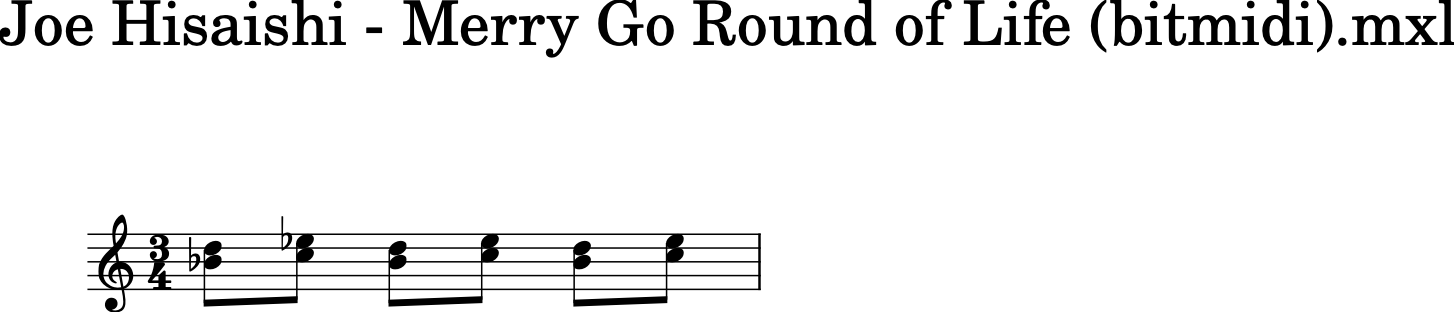

ic| len(m.notes): 6
ic| chd: <music21.chord.Chord B-4 D5>
ic| chd: <music21.chord.Chord C5 E-5>
ic| chd: <music21.chord.Chord B-4 D5>
ic| chd: <music21.chord.Chord C5 E-5>
ic| chd: <music21.chord.Chord B-4 D5>
ic| chd: <music21.chord.Chord C5 E-5>
ic| chd.notes: (<music21.note.Note B->, <music21.note.Note D>)
ic| chd.fullName: 'Chord {B-flat in octave 4 | D in octave 5} Eighth'
ic| type(chd.duration): <class 'music21.duration.Duration'>
ic| dur: <music21.duration.Duration 0.5>


<music21.duration.Duration 0.5>

In [6]:
m = part_ch2.measure(2)
m.show()
ic(len(m.notes)) # The 1st non-empty measure
for chd in m.notes:
    ic(chd)

chd: music21.chord.Chord = m.notes[0]  # A Chord, which contains multiple notes
ic(chd.notes)
ic(chd.fullName)
# ic(vars(chd))
ic(type(chd.duration))
dur: music21.duration.Duration = chd.duration
ic(dur)  # 0.5 means half of time span of a quarter note



#### Notes in a chord



In [7]:
note: music21.note.Note = chd.notes[0]
ic(note)
ic(vars(note))



ic| note: <music21.note.Note B->
ic| vars(note): {'_activeSite': None,
                 '_activeSiteStoredOffset': None,
                 '_cache': {},
                 '_chordAttached': <music21.chord.Chord B-4 D5>,
                 '_derivation': <Derivation of <music21.note.Note B-> from None>,
                 '_duration': <music21.duration.Duration 0.5>,
                 '_editorial': None,
                 '_naiveOffset': 0.0,
                 '_notehead': 'normal',
                 '_noteheadFill': None,
                 '_noteheadParenthesis': False,
                 '_priority': 0,
                 '_stemDirection': 'down',
                 '_storedInstrument': None,
                 '_style': <music21.style.NoteStyle object at 0x16b917580>,
                 '_volume': <music21.volume.Volume realized=1.0>,
                 'articulations': [],
                 'beams': <music21.beam.Beams>,
                 'expressions': [],
                 'groups': [],
                 'id

{'_activeSite': None,
 '_naiveOffset': 0.0,
 '_activeSiteStoredOffset': None,
 '_derivation': <Derivation of <music21.note.Note B-> from None>,
 '_style': <music21.style.NoteStyle object at 0x16b917580>,
 '_editorial': None,
 '_duration': <music21.duration.Duration 0.5>,
 '_priority': 0,
 '_cache': {},
 'id': 6189679328,
 'groups': [],
 'sites': <music21.sites.Sites at 0x16b925680>,
 'lyrics': [],
 'expressions': [],
 'articulations': [],
 'tie': None,
 '_notehead': 'normal',
 '_noteheadFill': None,
 '_noteheadParenthesis': False,
 '_stemDirection': 'down',
 '_volume': <music21.volume.Volume realized=1.0>,
 'linkage': 'tie',
 'beams': <music21.beam.Beams>,
 '_storedInstrument': None,
 '_chordAttached': <music21.chord.Chord B-4 D5>,
 'pitch': <music21.pitch.Pitch B-4>}

#### Get notes start time relative to a measure?
Doesn't seem to be part of the `Note` object, is it inferred instead, based on the sequential ordering of `.notes`



In [8]:
# ic(note._naiveOffset)
ic(note.offset)

ic(m.notes[3].notes[1].offset)



ic| note.offset: 0.0
ic| m.notes[3].notes[1].offset: 0.0


0.0

##### Confirm assumption with another measure
Confirmed, seems like concurrent notes in the same time slot is clusted into a whole chord



In [9]:
m = part_ch2.measure(5)
# m.show()

ic(len(m.notes))
for n in m.notes:
    ic(n, n.duration, len(n.notes))



ic| len(m.notes): 3
ic| n: <music21.chord.Chord F#4 A4>
    n.duration: <music21.duration.Duration 0.5>
    len(n.notes): 2
ic| n: <music21.chord.Chord E4 G4>
    n.duration: <music21.duration.Duration 0.5>
    len(n.notes): 2
ic| n: <music21.chord.Chord E-4 F#4>
    n.duration: <music21.duration.Duration 2.0>
    len(n.notes): 2


#### A chord has an offset instead
Looks like the correct `offset` is stored one level below the measure object, which makes sense



In [10]:
for n in m.notes:
    ic(n, n.offset)



ic| n: <music21.chord.Chord F#4 A4>, n.offset: 0.0
ic| n: <music21.chord.Chord E4 G4>, n.offset: 0.5
ic| n: <music21.chord.Chord E-4 F#4>, n.offset: 1.0


### Get pitch for a note
The numeric representation


In [11]:
p = note.pitch
# ic(vars(note))
ic(note, p)
ic(vars(p), dir(p))
ic(p.midi)



ic| note: <music21.note.Note B->, p: <music21.pitch.Pitch B-4>
ic| vars(p): {'_accidental': <music21.pitch.Accidental flat>,
              '_client': <music21.note.Note B->,
              '_groups': None,
              '_microtone': None,
              '_octave': 4,
              '_overridden_freq440': None,
              '_step': 'B',
              'defaultOctave': 4,
              'fundamental': None,
              'spellingIsInferred': False}
    dir(p): ['_DOC_ATTR',
             '_DOC_ORDER',
             '__annotations__',
             '__class__',
             '__deepcopy__',
             '__delattr__',
             '__dict__',
             '__dir__',
             '__doc__',
             '__eq__',
             '__format__',
             '__ge__',
             '__getattribute__',
             '__gt__',
             '__hash__',
             '__init__',
             '__init_subclass__',
             '__le__',
             '__lt__',
             '__module__',
             '__ne__',


70